# Ranking model for food recipe recommender system

## Introduction

In this analysis we will build a food recipe ranking model that can be used in recommender systems. We will build a user-item recommender system that can recommend recipes to users based on previous interactions. We will perform collaborative filtering with explicit feedback by using the recipes ratings as explicit user feedback. So given a user input ID, the system will return a list of ranked recipes IDs that might be of interest to that user based on that user's rated recipes.

Recommender systems used in production typically consist of two phases:

The **retrieval stage** plays a crucial role in picking an initial set of several hundred candidates out of a vast pool of options. Its primary aim is to swiftly eliminate all candidates that fail to pique the user's interest. Given that the retrieval model might need to sift through millions of candidates, it must be computationally efficient.

The next stage is the **ranking stage**, which further fine-tunes the outputs from the retrieval model to identify the optimal few recommendations. It will further narrow down the list of candidates retrieved during the retrieval stage and create a (ranked) shortlist of candidates.

In this analysis we will focus on building a **ranking model** that can used for ranking a list of candidates generated during the retrieval stage.

## Load data

In [220]:
import os
import pprint
import re
import sys
from ast import literal_eval
from typing import Dict, Text

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_recommenders as tfrs

In [221]:
NROWS=10000
BATCH_SIZE=128

### Load rating data

We will start the analysis by loading the interaction data and extracting the `user_id`, `recipe_id` and `rating`. For this proof-of-concept analysis we will only import the first 10000 entries for speeding up training iterations.

In [222]:
def load_data(
    file_path="./data/RAW_interactions.csv",
    cols=["user_id", "recipe_id", "rating"],
    nrows=NROWS,
):
    """Load ratings into Tensorflow dataset

    Returns:
        Tensorflow.dataset: Tensorflow dataset with ratings
    """
    ratings_df = pd.read_csv(
        file_path,
        usecols=cols,
        nrows=nrows,
    )

    if "user_id" in cols:
        ratings_df["user_id"] = ratings_df["user_id"].astype(str)

    if "recipe_id" in cols:
        ratings_df["recipe_id"] = ratings_df["recipe_id"].astype(str)

    ratings_df.fillna("", inplace=True)
    ratings_ds = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
    return ratings_ds


In [223]:
ratings = load_data(nrows=NROWS)

In [224]:
for x in ratings.take(5).as_numpy_iterator():
    pprint.pprint(x)

{'rating': 4, 'recipe_id': b'40893', 'user_id': b'38094'}
{'rating': 5, 'recipe_id': b'40893', 'user_id': b'1293707'}
{'rating': 4, 'recipe_id': b'44394', 'user_id': b'8937'}
{'rating': 5, 'recipe_id': b'85009', 'user_id': b'126440'}
{'rating': 5, 'recipe_id': b'85009', 'user_id': b'57222'}


### Create train and test data sets

For training and evaluating the ranking model we need to create a training and test data set. We will randomly shuffle the rating data and divide it into a training and test dataset using a 80/20 split.

In [225]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(NROWS, seed=42, reshuffle_each_iteration=False)

NR_TRAIN = np.floor(0.8 * NROWS)
NR_TEST = NROWS - NR_TRAIN

train = shuffled.take(NR_TRAIN)
test = shuffled.skip(NR_TRAIN).take(NR_TEST)

## Build ranking model

Before building the user and item models, we will get all unique user and recipe IDs, which will be used as fixed vocabularies for the StringLookup layer and are also necessary to determine the dimension of the subsequent Embedding layer. Now that we have the vocabulary sizes to create the user and item embeddings, we can proceed to building the ranking model.

In [226]:
unique_recipe_ids = np.unique(list(x['recipe_id'] for x in ratings.take(NROWS).as_numpy_iterator()))
unique_user_ids = np.unique(list(x['user_id'] for x in ratings.take(NROWS).as_numpy_iterator()))

Because a ranking model typically runs on fewer input candidates, the ranking model is not as computationally expensive as the retrieval model. We can therfore use a deeper model architecture.
The ranking model architecture we will define consists of the user and item embedding layers, which are concatenated and feed into the ranking model, which is an multi-layer perception with a two densely connected layers. We will also add dropout to both dense layers to perform model regularization and to reduce the risk of overfitting.

So the model will take user and recipe IDs as inputs, which will get embedded into feature vectors by the user amd item model layers. Those feature vecutors will subsequenlty get concatenated and passed into the rating model, which will output a single score, which is the predicted user rating for a specific user ID and recipe ID.

In [227]:
class RankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users
        self.user_embeddings = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_user_ids, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_user_ids) + 1, 
                    embedding_dimension,
                ),
            ]
        )

        # Compute embeddings for recipes
        self.item_embeddings = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_recipe_ids, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_recipe_ids) + 1, 
                    embedding_dimension,
                ),
            ]
        )

        # Compute rating predictions
        self.ratings = tf.keras.Sequential(
            [
                # Pass ratings through a multilayer perceptron
                tf.keras.layers.Dense(256, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                # Final outpt layer that will make the prdictions.
                tf.keras.layers.Dense(1),
            ]
        )

    def call(self, inputs):
        user_id, recipe_id = inputs

        user_embedding = self.user_embeddings(user_id)
        recipe_embedding = self.item_embeddings(recipe_id)

        return self.ratings(tf.concat([user_embedding, recipe_embedding], axis=1))


Once we have built the ranking model we can define the `FoodRecipeModel`, which is a `tfrs.models.Model` that combines the network model with a retrieval task. The retrieval task computes the loss and RMSE during traing. The FoodRecipeModel will take care of the training loop.

In [228]:
class FoodRecipeModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model((features["user_id"], features["recipe_id"]))

    def compute_loss(
        self, features: Dict[Text, tf.Tensor], training=False
    ) -> tf.Tensor:
        labels = features.pop("rating")

        rating_predictions = self(features)

        return self.task(labels=labels, predictions=rating_predictions)


We can now initialize and compile the model. We will also add the Keras `Adagrad` optimizer to optimize the ranking model. 

In [229]:
model = FoodRecipeModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05))

## Train ranking model

For improved perforance, we cache the train and data sets.

In [230]:
cached_train = train.shuffle(NROWS).batch(BATCH_SIZE).cache()
cached_test = test.batch(BATCH_SIZE).cache()

WE define a Keras callback that monitors the RMSE during training and will stop training if the RMSE does not improve during three consecutive training epochs. We also specify to return the best model weights in case of early stopping by setting `restore_best_weigghts=true`.

In [231]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="root_mean_squared_error",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

Now that we have cached the training set and passed the early stopping callbackc to the model we can start the training.

In [232]:
history = model.fit(cached_train, epochs=50, callbacks=es_callback)

Epoch 1/50
63/63 [==============================] - 2s 6ms/step - root_mean_squared_error: 1.5313 - loss: 2.3102 - regularization_loss: 0.0000e+00 - total_loss: 2.3102
Epoch 2/50
63/63 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.2410 - loss: 1.5232 - regularization_loss: 0.0000e+00 - total_loss: 1.5232
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - root_mean_squared_error: 1.1821 - loss: 1.3796 - regularization_loss: 0.0000e+00 - total_loss: 1.3796
Epoch 4/50
63/63 [==============================] - 0s 7ms/step - root_mean_squared_error: 1.0298 - loss: 1.0414 - regularization_loss: 0.0000e+00 - total_loss: 1.0414
Epoch 5/50
63/63 [==============================] - 1s 9ms/step - root_mean_squared_error: 0.7623 - loss: 0.5700 - regularization_loss: 0.0000e+00 - total_loss: 0.5700
Epoch 6/50
63/63 [==============================] - 0s 6ms/step - root_mean_squared_error: 0.5969 - loss: 0.3493 - regularization_loss: 0.0000e+00 - total_loss:

We can visualize the training loss and RMSE during training. We can observe that both training loss and RMSE are decreasing, indicating that the model performance is improving. 

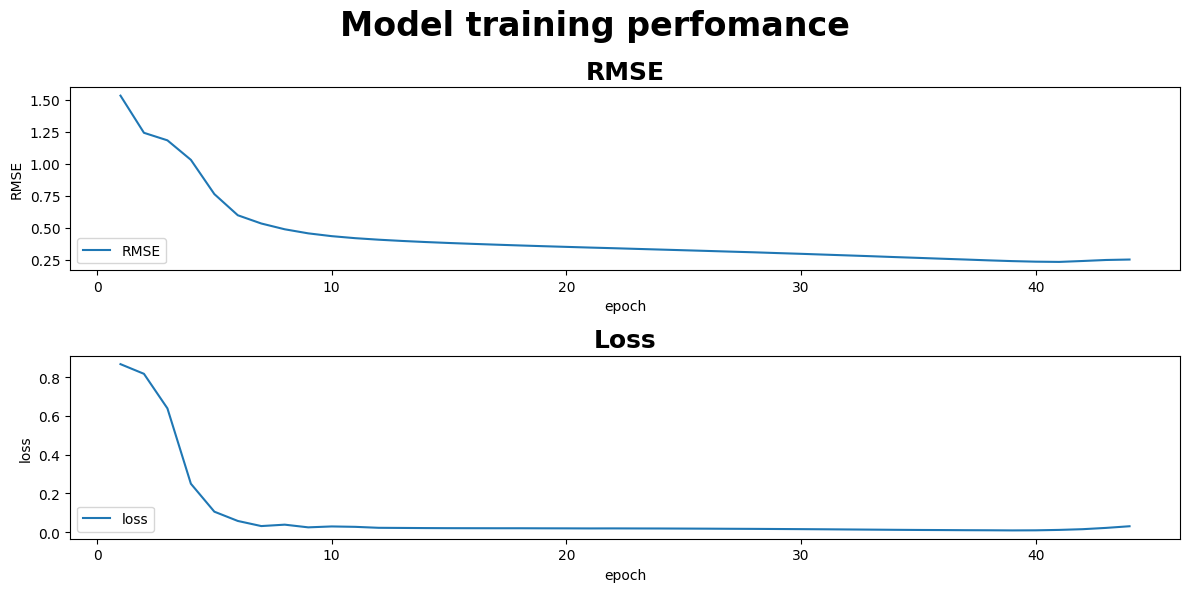

In [233]:
EPOCHS = list(range(1,len(history.history['root_mean_squared_error']) + 1))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle('Model training perfomance', fontsize=24, fontweight='bold')

ax1.plot(EPOCHS, history.history['root_mean_squared_error'])
ax1.set_title('RMSE', fontsize=18, fontweight='bold')
ax1.set_xlabel('epoch')
ax1.set_ylabel('RMSE')
ax1.legend(['RMSE'], loc='lower left')

ax2.plot(EPOCHS, history.history['loss'])
#ax2.plot(EPOCHS, history.history['val_loss'])
ax2.set_title('Loss', fontsize=18, fontweight='bold')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend(['loss'], loc='lower left')

fig.tight_layout()


## Model evaluation

 We can observe that the ranking model performs worse on the test set compared to the training set. The model might be overfitting because it is memorizing data that is has seen. Models with many parameters are prone to overfitting. We could mediate this by increasing the regularization in the embedding layers in the user and item models. We could also increase the `Dropout` rate in the Dense layers of the ranking model.

In [234]:
pd.DataFrame([model.evaluate(cached_test, return_dict=True)])

16/16 [==============================] - 0s 4ms/step - root_mean_squared_error: 1.3924 - loss: 1.9466 - regularization_loss: 0.0000e+00 - total_loss: 1.9466


,root_mean_squared_error,loss,regularization_loss,total_loss
0,1.392353,2.03689,0,2.03689


## Model predictions

### Compute ranking scores

In [235]:
def compute_ranking(user_id, recipe_ids, verbose=True):
    ratings_pred = {}

    for recipe_id in recipe_ids:
        ratings_pred[recipe_id] = model(
            {"user_id": np.array([user_id]), "recipe_id": np.array([recipe_id])}
        )

    if verbose:
        print("Ratings:")
        for recipe_id, score in sorted(ratings_pred.items(), key=lambda x: x[1], reverse=True):
            print(f"{recipe_id}: {score[0][0]:.4f}")

    return ratings_pred

Let's get the first 100 recipe IDs from the test set to compute the rankings.

In [236]:
test_user = "38094"
test_recipe_ids = np.unique(list(x['recipe_id'] for x in test.take(NROWS).as_numpy_iterator()))[:100]

Using a test user ID and a candidate list containing 100 recipe IDd. We can commpute the ranking scores for all canidate recipe IDs.

In [237]:
ranking = compute_ranking(user_id=test_user, recipe_ids=test_recipe_ids, verbose=False)

We can also inspect the distribution of the predicted ratings for out test user. We can observer that the scores follow a normal distribution with mean rating around 5.

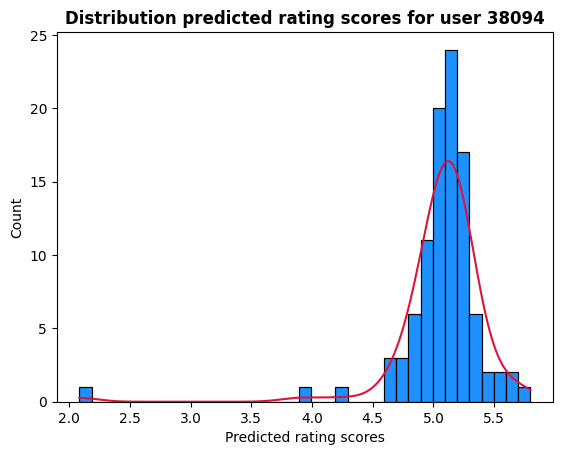

In [238]:
def get_scores(ranking_dict):
    sorted_list = [
        (int(recipe_id), float(scores[0][0]))
        for recipe_id, scores in sorted(
            ranking_dict.items(), key=lambda x: x[1], reverse=True
        )
    ]
    _, scores_pred = zip(*sorted_list)
    return scores_pred

scores_pred = get_scores(ranking_dict=ranking)
ax = sns.histplot(data=scores_pred, 
                    color='crimson',
                    facecolor='dodgerblue',
                    kde=True,
                    stat='count')
ax.set_xlabel("Predicted rating scores")
ax.set_title(
        f"Distribution predicted rating scores for user {test_user}",
        fontsize=12,
        fontweight="bold",
);

### Annotate ranked items

We create a lookup table that maps recipe IDs to recipe name and description. We can then use this lookup table to annotate the recipe IDs.

In [239]:
mapping_df = pd.read_csv(
    "./data/RAW_recipes.csv", usecols=["name", "id", "description"], index_col="id"
)
mapping_df.head()

,name,description
id,,
137739,arriba baked winter squash mexican style,autumn is my favorite time of year to cook! th...
31490,a bit different breakfast pizza,this recipe calls for the crust to be prebaked...
112140,all in the kitchen chili,this modified version of 'mom's' chili was a h...
59389,alouette potatoes,"this is a super easy, great tasting, make ahea..."
44061,amish tomato ketchup for canning,my dh's amish mother raised him on this recipe...


In [215]:
def annotate_top_k(ranking_dict, lookup_table=mapping_df, k=5):
    sorted_list = [
        (int(recipe_id), float(scores[0][0]))
        for recipe_id, scores in sorted(
            ranking_dict.items(), key=lambda x: x[1], reverse=True
        )
    ]
    ids, scores_pred = zip(*sorted_list[:k])
    annotated_df = lookup_table.loc[ids, ["name", "description"]].copy()
    annotated_df["name"] = annotated_df["name"].apply(lambda x: re.sub(" +", " ", x))
    annotated_df["description"] = (
        annotated_df["description"].fillna("NA").apply(lambda x: re.sub(" +", " ", x))
    )
    annotated_df["score"] = scores_pred
    return annotated_df

We can now extract the first top k ranked items and annotate the recipe IDs with recipe name and description. We will extract the first 20 items and annotate them.

In [240]:
ranked_df = annotate_top_k(ranking_dict=ranking, k=20)
ranked_df

,name,description,score
id,,,
138359,sun dried tomato cream sauce,i'm in heaven when i have this. it's so rich &...,5.797815
117220,penne with slow roasted cherry tomatoes and go...,"from sarah moulton on sara's secrets, this is ...",5.696644
151223,romaine with oranges and pecans,i was very suprized not to fine this recipe on...,5.631363
112973,basic mashed potatoes,you can use any kind of potato in this recipe....,5.561831
100104,pesche italian peach wedding cookies,"years ago, my grandmother and great-aunt went ...",5.559312
1207,country rice pudding,NA,5.416039
101583,potato green pepper tomato gratin,this is cooked similar to a scalloped potato r...,5.405591
104084,peanut butter and pickle sandwiches,don't dismiss it until you try it. you probabl...,5.364321
135365,warm roast pumpkin salad,looking for australian recipes for the zaar wo...,5.351986


We can alos visualize those top 20 ranked recipes with a simple bar plot.

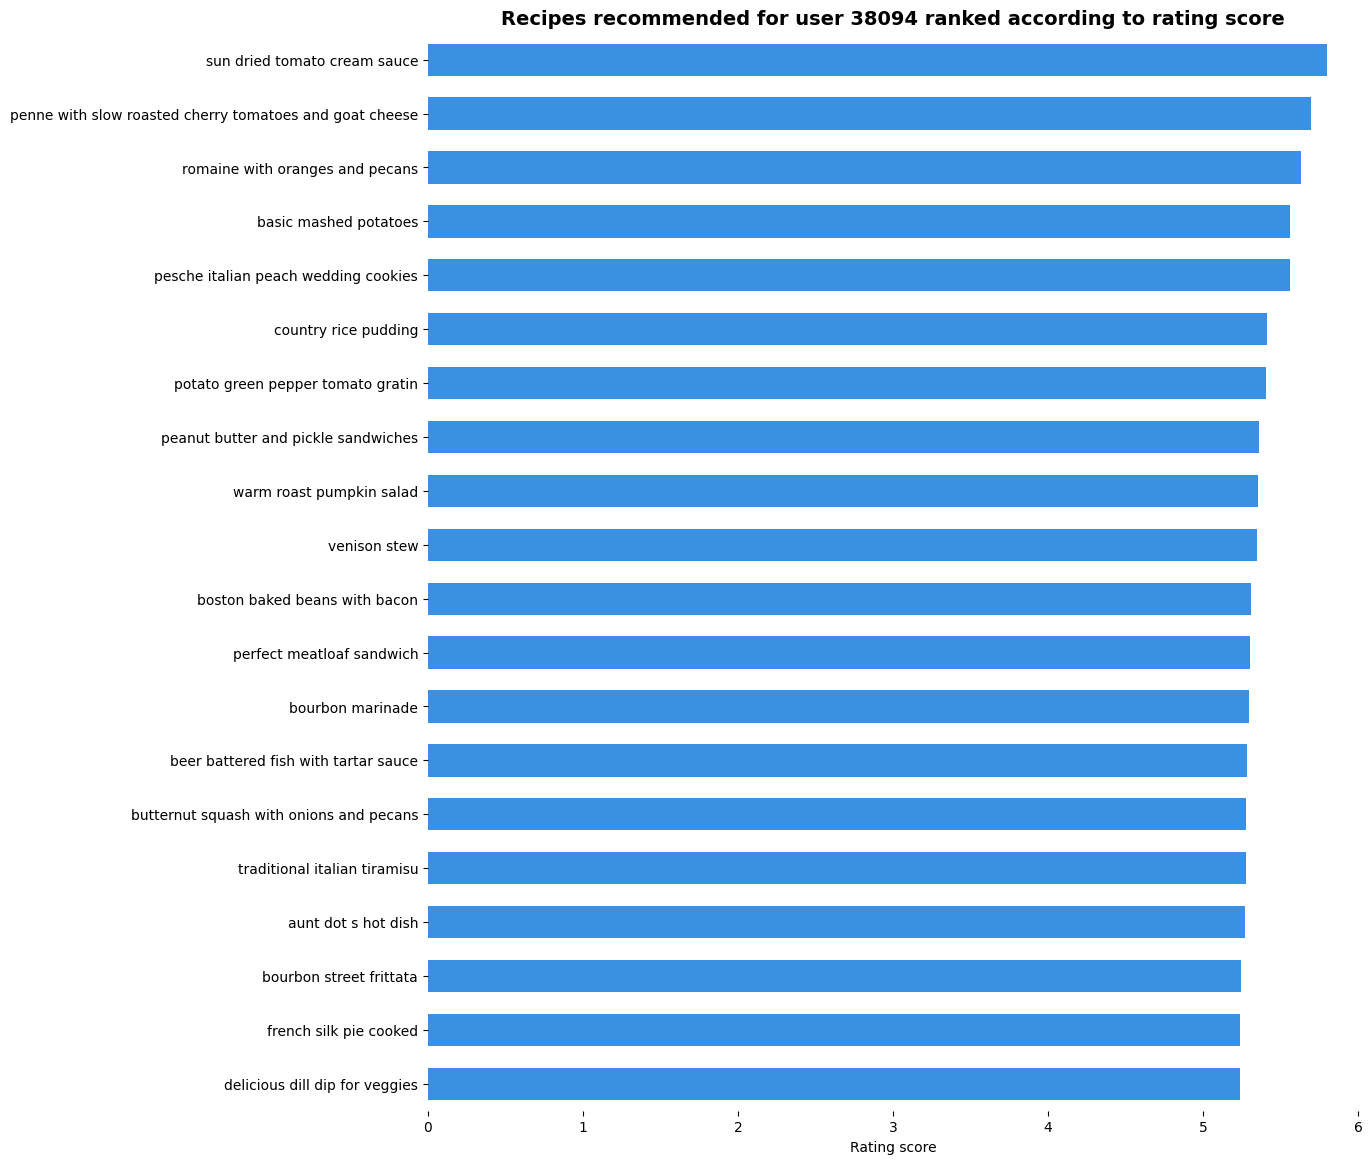

In [242]:
plt.figure(figsize=(12, 14))
ax = sns.barplot(
        x="score",
        y="name",
        data=ranked_df,
        label="Rating score",
        color="dodgerblue",
        width=0.6,
)
ax.set(xlim=(0, 6), ylabel="", xlabel="Rating score")
ax.set_title(
        f"Recipes recommended for user {test_user} ranked according to rating score",
        fontsize=14,
        fontweight="bold",
)
sns.despine(left=True, bottom=True)
